# Лабораторная работа №3 Основные виды нейросетей (CNN и RNN)

### Вариант - 3

### Цель работы: реализация сверточных и рекуррентных сетей, исследование проблемы затухающих и взрывающихся градиентов.

## Сверточные сети

Вернемся в очередной раз к датасету MNIST. Для начала загрузим данные и определим несколько полезных функций как на прошлом семинаре.

In [1]:
# Загрузка зависимостей
import util

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

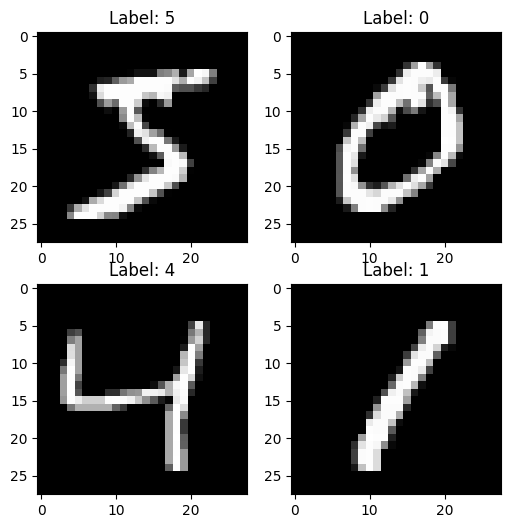

In [3]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(f"Label: {y_train[i]}")
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [4]:
from util import iterate_minibatches

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print(f"Epoch {epoch} of {n_epochs}")
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print(f"Epoch {epoch} error = {1 - val_acc_log[-1][1]:.2%}")
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

**Задание 1:** Реализуйте сверточную сеть, которая состоит из двух последовательных применений свертки, relu и max-пулинга, а потом полносвязного слоя.

Подберите параметры так, чтобы на выходе последнего слоя размерность тензора была 4 x 4 x 16. В коде ниже используется обертка nn.Sequential, ознакомьтесь с ее интерфейсом.

Добейтесь, чтобы ошибка классификации после обучения (см. ниже) была не выше 1.5%.

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Linear(28*28, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

Посчитаем количество обучаемых параметров сети.

In [6]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 10330


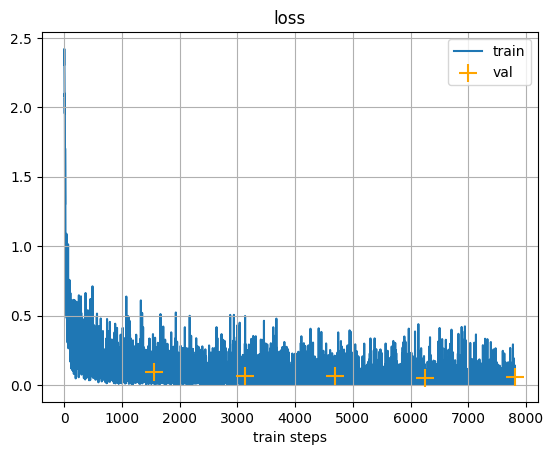

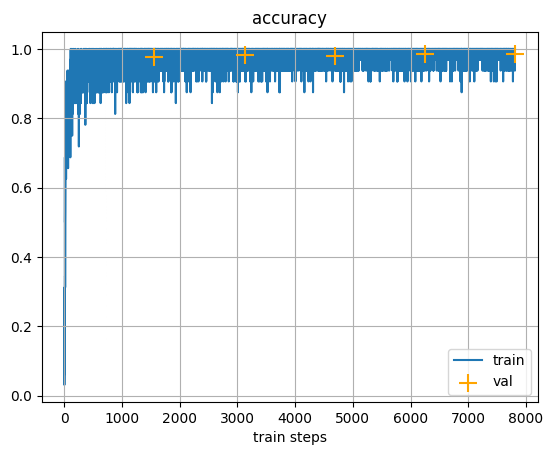

Epoch 4 error = 1.46%
Final error: 1.46%
CPU times: total: 7min 7s
Wall time: 1min 51s


In [7]:
%%time

opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
train(model, opt, 5)

## Рекуррентные сети

Для рекуррентных сетей используем датасет с именами и будем определять из какого языка произошло данное имя. Для этого построим рекуррентную сеть, которая с именами на уровне символов. Для начала скачаем файлы и конвертируем их к удобному формату (можно не особо вникать в этот код).

In [8]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


Определим несколько удобных функций для конвертации букв и слов в тензоры.

**Задание 2:** напишите последнюю функцию для конвертации слова в тензор.

In [9]:
# Найдиём буквенный индекс по all_letters, например, "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Просто для демонстрации превратим букву в тензор <1 x n_letters>
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Преобразуем строку в <line_length x 1 x n_letters>,
# или массив векторов с одной горячей буквой
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


**Задание 3:** Реализуйте однослойную рекуррентную сеть.

In [10]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size
        self.input_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = F.relu(self.input_to_hidden(combined))
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

Предсказание будем осуществлять при помощи линейного класссификатора поверх скрытых состояний сети.

In [11]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

Проверим, что все корректно работает: выходы классификаторы должны быть лог-вероятностями.

In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.7722, -2.9749, -2.8073, -2.8387, -2.8891, -2.9646, -3.0116, -2.8688,
         -2.8756, -2.9336, -2.8103, -2.9359, -2.9507, -2.8829, -2.8072, -2.8762,
         -2.9400, -2.9252]], grad_fn=<LogSoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.7722, -2.9749, -2.8073, -2.8387, -2.8891, -2.9646, -3.0116, -2.8688,
         -2.8756, -2.9336, -2.8103, -2.9359, -2.9507, -2.8829, -2.8072, -2.8762,
         -2.9400, -2.9252]], grad_fn=<LogSoftmaxBackward0>)
tensor(1.0000, grad_fn=<SumBackward0>)


Для простоты в этот раз будем оптимизировать не по мини-батчам, а по отдельным примерам. Ниже несколько полезных функций для этого.

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = names\Dutch / line = Alst
category = names\Irish / line = Dubhan
category = names\Greek / line = Close
category = names\Dutch / line = Sniders
category = names\Czech / line = Sponer
category = names\Chinese / line = Chao
category = names\Czech / line = Kreutschmer
category = names\Greek / line = Metrofanis
category = names\Arabic / line = Nader
category = names\German / line = Vo


**Задание 4:** Реализуйте вычисление ответа в функции train. Если все сделано правильно, то точность на обучающей выборке должна быть не менее 70%.

  0%|          | 0/50000 [00:00<?, ?it/s]

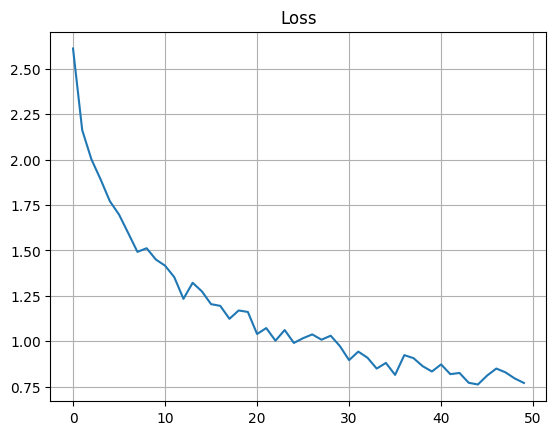

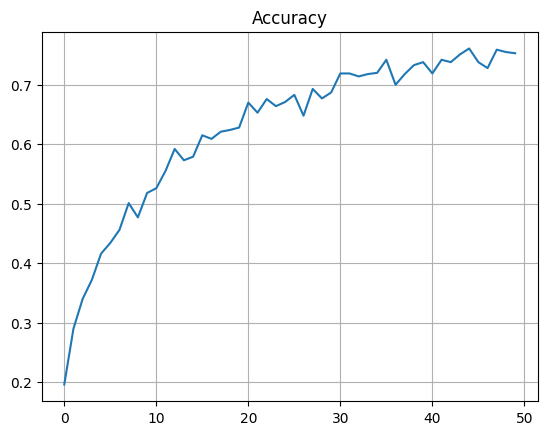

In [15]:
from tqdm.auto import tqdm

def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = rnncell(line_tensor[i], hidden)
        hidden = output

    output = classifier(output)

    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    acc = (categoryFromOutput(output)[0] == category)

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0
        
plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()

## Затухающие и взрывающиеся градиенты

Эксперименты будем проводить опять на датасете MNIST, но будем работать с полносвязными сетями. В этом разделе мы не будем пытаться подобрать более удачную архитектуру, нам интересно только посмотреть на особенности обучения глубоких сетей.

In [16]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

Для экспериментов нам понадобится реализовать сеть, в которой можно легко менять количество слоев. Также эта сеть должна сохранять градиенты на всех слоях, чтобы потом мы могли посмотреть на их величины.

**Задание 5**: допишите недостающую часть кода ниже.

In [17]:
class DeepDenseNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation
        
        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]
        
        for i in range(n_layers - 1):
            layer = nn.Linear(hidden_size, hidden_size)
            self.layers.append(layer)
            self.weights.append(layer.weight)
            self.layers.append(self.activation)
        
        self.seq = nn.Sequential(*self.layers)
        
        for l in self.weights:
            l.retain_grad()
        
    def forward(self, x):
        out = self.seq(x)
        return F.log_softmax(out, dim=-1)

Модифицируем наши функции обучения, чтобы они также рисовали графики изменения градиентов.

In [18]:
import scipy.sparse.linalg

def train_epoch_grad(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # подготовка данных
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        # вычисление градиентов
        loss.backward()
        # сделай шаг
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
        for g, l in zip(grads, model.weights):
            g.append(np.linalg.norm(l.grad.numpy()))
    return loss_log, acc_log, grads


def train_grad(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    batchsize = 32

    for epoch in range(n_epochs):
        print(f"Epoch {epoch} of {n_epochs}")
        train_loss, train_acc, grads = train_epoch_grad(model, opt, batchsize=batchsize)
        if grads_log is None:
            grads_log = grads
        else:
            for a, b in zip(grads_log, grads):
                a.extend(b)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        # отображение всех показателей
        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')    

        plt.figure()
        all_vals = []
        for i, g in enumerate(grads_log):
            w = np.ones(100)
            w /= w.sum()
            vals = np.convolve(w, g, mode='valid')
            plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log))))
            all_vals.extend(vals)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

**Задание 6:**

- Обучите сети глубины 10 и больше с сигмоидой в качестве активации. Исследуйте, как глубина влияет на качество обучения и поведение градиентов на далеких от выхода слоях.
- Теперь замените активацию на ReLU и посмотрите, что получится.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Определение архитектуры нейронной сети
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, activation):
        super(DeepNeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        if activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'relu':
            layers.append(nn.ReLU())
        for _ in range(depth - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'relu':
                layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Функция обучения
def train(model, optimizer, criterion, X_train, y_train, batch_size=32, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            inputs = torch.Tensor(X_train[i:i+batch_size])
            labels = torch.LongTensor(y_train[i:i+batch_size])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(X_train)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    return train_losses

# Функция тестирования
def test(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        inputs = torch.Tensor(X_test)
        labels = torch.LongTensor(y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy on test set: {100 * accuracy:.2f}%')
    return accuracy


Training...
Epoch 1/10, Loss: 2.3160
Epoch 2/10, Loss: 2.3058
Epoch 3/10, Loss: 2.3058
Epoch 4/10, Loss: 2.3055
Epoch 5/10, Loss: 2.3054
Epoch 6/10, Loss: 2.3053
Epoch 7/10, Loss: 2.3052
Epoch 8/10, Loss: 2.3051
Epoch 9/10, Loss: 2.3050
Epoch 10/10, Loss: 2.3050

Testing...
Accuracy on test set: 6.50%


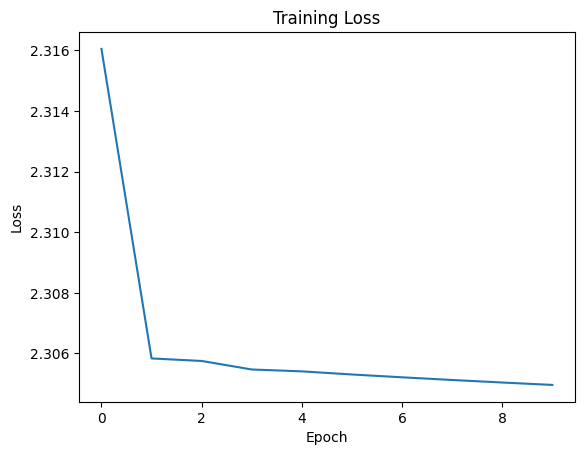

In [20]:
# Гиперпараметры
input_size = 100
hidden_size = 64
output_size = 10
depth = 10
activation = 'sigmoid'  # 'sigmoid' или 'relu'
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Создание случайных данных для обучения и тестирования
X_train = np.random.randn(1000, input_size)
y_train = np.random.randint(output_size, size=1000)
X_test = np.random.randn(200, input_size)
y_test = np.random.randint(output_size, size=200)

# Создание модели
model = DeepNeuralNetwork(input_size, hidden_size, output_size, depth, activation)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
print("Training...")
train_losses = train(model, optimizer, criterion, X_train, y_train, batch_size=batch_size, num_epochs=num_epochs)

# Тестирование модели
print("\nTesting...")
accuracy = test(model, X_test, y_test)

# Визуализация процесса обучения
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Training deep neural network with sigmoid activation...
Epoch 1/10, Loss: 2.3149
Epoch 2/10, Loss: 2.3058
Epoch 3/10, Loss: 2.3057
Epoch 4/10, Loss: 2.3054
Epoch 5/10, Loss: 2.3054
Epoch 6/10, Loss: 2.3053
Epoch 7/10, Loss: 2.3052
Epoch 8/10, Loss: 2.3051
Epoch 9/10, Loss: 2.3050
Epoch 10/10, Loss: 2.3049

Testing...
Accuracy on test set: 6.50%


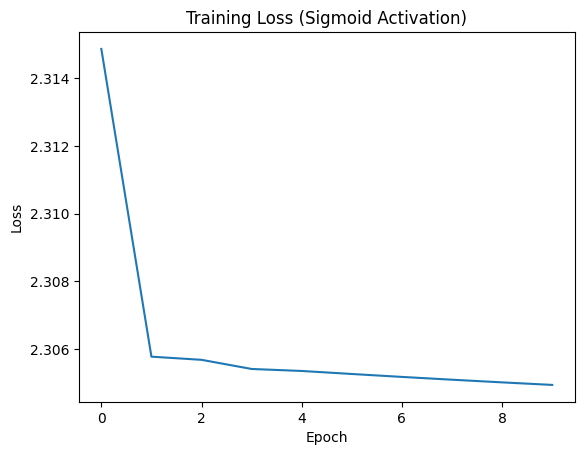


Accuracy on test set with sigmoid activation: 6.50%


In [21]:
# Обучение сети с сигмоидной активацией
print("Training deep neural network with sigmoid activation...")
model_sigmoid = DeepNeuralNetwork(input_size, hidden_size, output_size, depth, activation='sigmoid')
optimizer_sigmoid = optim.Adam(model_sigmoid.parameters(), lr=learning_rate)
train_losses_sigmoid = train(model_sigmoid, optimizer_sigmoid, criterion, X_train, y_train, batch_size=batch_size, num_epochs=num_epochs)

# Тестирование модели с сигмоидной активацией
print("\nTesting...")
accuracy_sigmoid = test(model_sigmoid, X_test, y_test)

# Визуализация процесса обучения
plt.plot(train_losses_sigmoid)
plt.title('Training Loss (Sigmoid Activation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f'\nAccuracy on test set with sigmoid activation: {100 * accuracy_sigmoid:.2f}%')


Training deep neural network with ReLU activation...
Epoch 1/10, Loss: 2.3055
Epoch 2/10, Loss: 2.3025
Epoch 3/10, Loss: 2.2992
Epoch 4/10, Loss: 2.2596
Epoch 5/10, Loss: 2.1540
Epoch 6/10, Loss: 2.0017
Epoch 7/10, Loss: 1.8293
Epoch 8/10, Loss: 1.8138
Epoch 9/10, Loss: 1.8587
Epoch 10/10, Loss: 1.8942

Testing...
Accuracy on test set: 10.00%


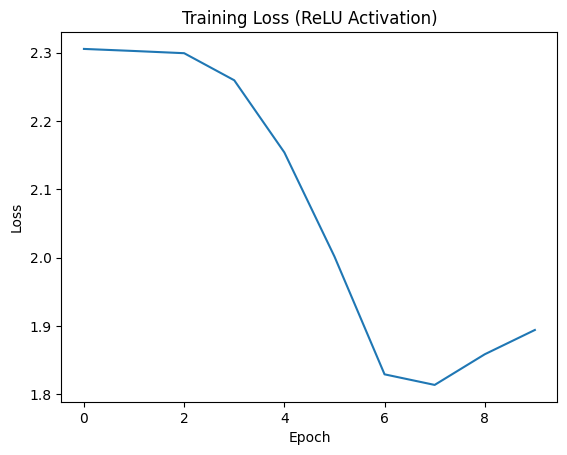


Accuracy on test set with ReLU activation: 10.00%


In [22]:
# Обучение сети с ReLU активацией
print("Training deep neural network with ReLU activation...")
model_relu = DeepNeuralNetwork(input_size, hidden_size, output_size, depth, activation='relu')
optimizer_relu = optim.Adam(model_relu.parameters(), lr=learning_rate)
train_losses_relu = train(model_relu, optimizer_relu, criterion, X_train, y_train, batch_size=batch_size, num_epochs=num_epochs)

# Тестирование модели с ReLU активацией
print("\nTesting...")
accuracy_relu = test(model_relu, X_test, y_test)

# Визуализация процесса обучения
plt.plot(train_losses_relu)
plt.title('Training Loss (ReLU Activation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f'\nAccuracy on test set with ReLU activation: {100 * accuracy_relu:.2f}%')


**Контрольные вопросы:**

- Почему сверточные сети обладают таким преимуществом именно для изображений?
- Почему несмотря на малое количество параметров обучение сверточных сетей занимает так много времени?

**1)Преимущество сверточных сетей для изображений:**

- Локальность признаков: Сверточные сети способны улавливать локальные паттерны в изображениях благодаря операции свертки, которая позволяет обнаруживать признаки в разных областях изображения без явного указания их положения.

- Параметрическая эффективность: Сверточные слои используют наборы ядер (фильтров), которые общие для всех пикселей входного изображения. Это позволяет значительно сократить количество параметров по сравнению с полносвязными сетями, что делает модели более компактными и менее склонными к переобучению.

- Инвариантность к трансформациям: Сверточные сети способны сохранять эффективность даже при изменениях масштаба, поворотах и сдвигах изображений благодаря операциям свертки и пулинга, которые обеспечивают некоторую степень инвариантности к таким трансформациям.

- Построение иерархии признаков: Многократное применение сверточных слоев позволяет создавать иерархию признаков, начиная с простых локальных паттернов на более низких уровнях и заканчивая более сложными абстракциями на более высоких уровнях.

**2)Время обучения сверточных сетей:**

- Вычислительная сложность: Обучение сверточных сетей включает в себя выполнение большого количества операций свертки и пулинга на каждом уровне сети, что требует значительных вычислительных ресурсов.

- Объем данных: Обучение моделей, особенно глубоких, требует большого объема данных для обучения. Проведение нескольких эпох обучения на большом наборе данных может занять много времени.

- Размер параметров: Хотя количество параметров в сверточных сетях обычно меньше, чем в полносвязных сетях, но глубокие архитектуры могут содержать миллионы параметров, что также влияет на время обучения.

- Алгоритм оптимизации: Применение эффективных алгоритмов оптимизации, таких как стохастический градиентный спуск с моментом или адаптивные методы оптимизации, может ускорить процесс обучения. Однако даже с использованием таких методов обучение глубоких сверточных сетей может занимать много времени.